In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import os, zipfile
ZIP_PATH = '/content/drive/MyDrive/archive (1).zip'
EXTRACT_PATH = '/content/flickr8k'


if not os.path.exists(EXTRACT_PATH):
    os.makedirs(EXTRACT_PATH, exist_ok=True)
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("Dataset extracted to:", EXTRACT_PATH)
else:
    print("Dataset already extracted.")


Dataset already extracted.


In [ ]:
# Setup - paths
import os

BASE_DIR = '/content/flickr8k'
IMG_DIR = os.path.join(BASE_DIR, 'Images')
CAPTIONS_FILE = os.path.join(BASE_DIR, 'captions.txt')
WORKING_DIR = '/content/working'
os.makedirs(WORKING_DIR, exist_ok=True)

print("Image dir:", IMG_DIR)
print("Captions file:", CAPTIONS_FILE)


Image dir: /content/flickr8k/Images
Captions file: /content/flickr8k/captions.txt


In [ ]:
#Imports & enable HPC features
import json
import pickle
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model

# Enable mixed precision + XLA
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision policy:", mixed_precision.global_policy().name)

tf.config.optimizer.set_jit(True)
print("XLA JIT enabled:", tf.config.optimizer.get_jit())


Mixed precision policy: mixed_float16
XLA JIT enabled: autoclustering


In [ ]:
#Load captions and mapping
def load_captions_file(path):
    mapping = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line: continue
            try:
                file_and_index, caption = line.split('\t')
                imgfile = file_and_index.split('#')[0]
            except ValueError:
                parts = line.split()
                imgfile = parts[0]
                caption = ' '.join(parts[1:])
            image_id = os.path.splitext(imgfile)[0]
            caption = caption.lower()
            caption = 'startseq ' + caption + ' endseq'
            mapping.setdefault(image_id, []).append(caption)
    return mapping

mapping = load_captions_file(CAPTIONS_FILE)
print("Loaded captions for", len(mapping), "images.")


Loaded captions for 8092 images.


In [ ]:
#Parallel feature extraction
def extract_features_tfdata(img_dir, img_size=(224,224), batch=64, save_path=None):
    base_vgg = VGG16(weights='imagenet')
    feat_model = Model(inputs=base_vgg.inputs, outputs=base_vgg.layers[-2].output)
    pattern = os.path.join(img_dir, '*.jpg')
    ds = tf.data.Dataset.list_files(pattern, shuffle=False)

    def _load_and_preprocess(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        img = preprocess_input(img)
        return path, img

    ds = ds.map(_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)

    features = {}
    for batch_paths, batch_imgs in ds:
        feats = feat_model(batch_imgs, training=False)
        for p, f in zip(batch_paths.numpy(), feats.numpy()):
            fname = os.path.basename(p.decode('utf-8'))
            image_id = os.path.splitext(fname)[0]
            features[image_id] = f.reshape((1, -1))
    if save_path:
        with open(save_path, 'wb') as fh:
            pickle.dump(features, fh)
    return features

features_path = os.path.join(WORKING_DIR, 'features.pkl')
if os.path.exists(features_path):
    with open(features_path, 'rb') as f:
        features = pickle.load(f)
    print("Loaded cached features.")
else:
    features = extract_features_tfdata(IMG_DIR, batch=64, save_path=features_path)
    print("Extracted features for", len(features), "images.")


Loaded cached features.


In [ ]:
#Tokenize captions
all_captions = []
for caps in mapping.values():
    all_captions.extend(caps)

tokenizer = Tokenizer(oov_token=None)
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

mapping_seqs = {}
max_length = 0
for img_id, caps in mapping.items():
    seqs = tokenizer.texts_to_sequences(caps)
    mapping_seqs[img_id] = seqs
    for s in seqs:
        if len(s) > max_length:
            max_length = len(s)
print("Vocab size:", vocab_size, "Max length:", max_length)


Vocab size: 8415 Max length: 38


In [ ]:
#Train/test split + dataset

all_ids = sorted(list(mapping.keys()))
split_idx = int(0.8 * len(all_ids))
train_ids = set(all_ids[:split_idx])
test_ids = all_ids[split_idx:]
BATCH = 256

def tf_data_generator():
    """A generator function that yields (inputs, outputs) for the model."""
    while True:
        # Use np.random.choice with `list(train_ids)` to avoid TypeError
        batch_ids = np.random.choice(list(train_ids), size=BATCH)
        for img_id in batch_ids:
            if img_id not in features: continue
            feat = features[img_id].reshape(-1)
            seqs = mapping_seqs[img_id]
            for seq in seqs:
                for i in range(1, len(seq)):
                    in_seq = pad_sequences([seq[:i]], maxlen=max_length, padding='post')[0]
                    out_id = seq[i]
                    out_onehot = np.zeros(vocab_size, dtype=np.float32)
                    out_onehot[out_id] = 1.0

                    # Yield a tuple of (inputs, outputs)
                    yield (feat.astype(np.float32), in_seq.astype(np.int32)), out_onehot


ds_train = tf.data.Dataset.from_generator(
    tf_data_generator,
    output_signature=(
        (tf.TensorSpec(shape=(4096,), dtype=tf.float32),
         tf.TensorSpec(shape=(max_length,), dtype=tf.int32)),
        tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)
    )
).shuffle(2048).batch(BATCH).prefetch(tf.data.AUTOTUNE)

# Calculate the number of steps per epoch
num_samples = sum(len(mapping_seqs[i]) for i in train_ids)
steps_per_epoch = num_samples // BATCH
print(f"📊 Using a generator. Estimated steps per epoch: {steps_per_epoch}")

📊 Using a generator. Estimated steps per epoch: 126


In [ ]:
#Build model inside MirroredStrategy
strategy = tf.distribute.MirroredStrategy()
print("GPUs:", strategy.num_replicas_in_sync)

with strategy.scope():
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.4)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.4)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', dtype='float32')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


GPUs: 1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 38)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 38, 256)   │  2,154,240 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 38, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 38)        │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8415)      │  2,162,655 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,956,831 (22.72 MB)

 Trainable params: 5,956,831 (22.72 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#train
EPOCHS = 20
history = model.fit(ds_train, epochs=EPOCHS, steps_per_epoch=steps_per_epoch)
model.save(os.path.join(WORKING_DIR, 'caption_model_gpu.h5'))

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.0955 - loss: 6.1471
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.1774 - loss: 4.9288
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 0.2173 - loss: 4.6258
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.2615 - loss: 4.2698
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.2725 - loss: 4.0922
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.2802 - loss: 3.9237
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.2998 - loss: 3.7987
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.3023 - loss: 3.7706
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.3114 - loss: 3.6661
Epoch 10/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.3210 - loss: 3.5635
Epoch 11/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.3201 - loss: 3.5711
Epoch 12/20
126/126

In [ ]:

#Batched greedy decode evaluation

from nltk.translate.bleu_score import corpus_bleu
import tensorflow as tf

test_feat_ids = [img for img in test_ids if img in features]
test_feats = np.concatenate([features[i] for i in test_feat_ids], axis=0).astype(np.float32)

start_token = tokenizer.word_index['startseq']
end_token  = tokenizer.word_index['endseq']

@tf.function
def greedy_decode_batch(model, feats_batch, max_length, start_token, end_token):
    B = tf.shape(feats_batch)[0]
    seqs = tf.fill([B, 1], start_token)
    finished = tf.zeros([B], dtype=tf.bool)
    time = tf.constant(0, dtype=tf.int32)

    def loop_cond(time, seqs, finished):
        return tf.logical_not(tf.reduce_all(finished)) and time < max_length - 1

    def loop_body(time, seqs, finished):
        padlen = max_length - tf.shape(seqs)[1]

        # Use post-padding, consistent with training
        seqs_in = tf.pad(seqs, [[0, 0], [0, padlen]], "CONSTANT", constant_values=0)

        preds = model([feats_batch, seqs_in], training=False)

        next_id = tf.argmax(preds, axis=-1)

        # Cast next_id to the same type as seqs
        next_id = tf.cast(next_id, seqs.dtype)

        seqs = tf.concat([seqs, tf.expand_dims(next_id, 1)], axis=1)
        finished |= tf.equal(next_id, end_token)

        return time + 1, seqs, finished


    _, seqs, _ = tf.while_loop(
        loop_cond,
        loop_body,
        loop_vars=[time, seqs, finished],
        shape_invariants=[
            time.get_shape(),
            tf.TensorShape([None, None]),
            finished.get_shape()
        ]
    )
    return seqs

preds, refs = [], []
BATCH_EVAL = 128
for i in range(0, len(test_feats), BATCH_EVAL):
    batch_feats = tf.convert_to_tensor(test_feats[i:i+BATCH_EVAL])
    seqs = greedy_decode_batch(model, batch_feats, max_length, start_token, end_token).numpy().tolist()
    for seq in seqs:
        words = []
        for idx in seq:
            w = tokenizer.index_word.get(idx)
            if w is None or w == 'startseq': continue
            if w == 'endseq': break
            words.append(w)
        preds.append(words)
    for img_id in test_feat_ids[i:i+BATCH_EVAL]:
        refs.append([cap.split()[1:-1] for cap in mapping[img_id]])

print("✅ BLEU-1:", corpus_bleu(refs, preds, weights=(1,0,0,0)))
print("✅ BLEU-2:", corpus_bleu(refs, preds, weights=(0.5,0.5,0,0)))
print("✅ BLEU-3:", corpus_bleu(refs, preds, weights=(0.33,0.33,0.33,0)))
print("✅ BLEU-4:", corpus_bleu(refs, preds, weights=(0.25,0.25,0.25,0.25)))

✅ BLEU-1: 0.5032018442622951
✅ BLEU-2: 0.3195194408405791
✅ BLEU-3: 0.18976846679043854
✅ BLEU-4: 0.10521571823559837


In [ ]:
# save
with open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'wb') as f:
    pickle.dump(tokenizer, f)
with open(os.path.join(WORKING_DIR, 'mapping.pkl'), 'wb') as f:
    pickle.dump(mapping, f)
print("Saved tokenizer and mapping to", WORKING_DIR)



Saved tokenizer and mapping to /content/working


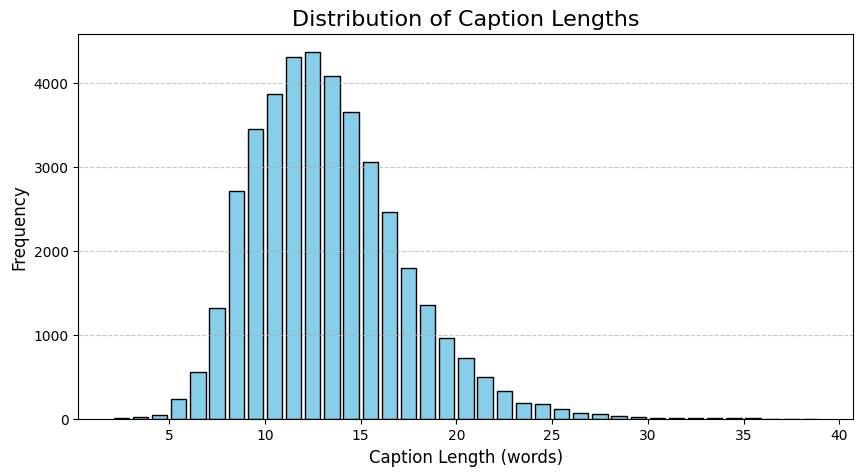

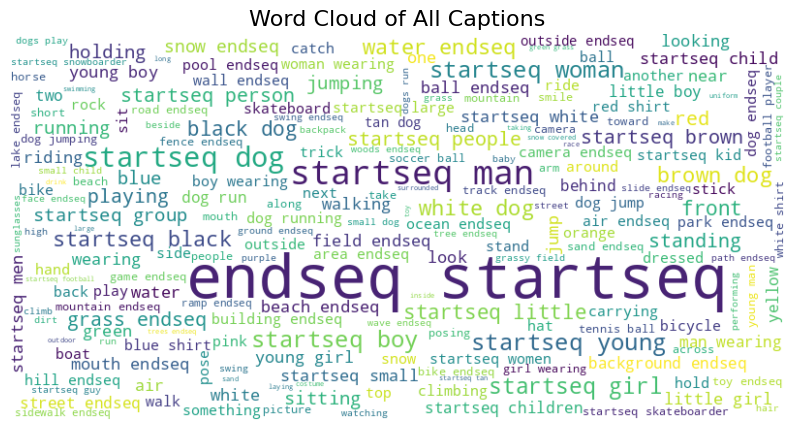

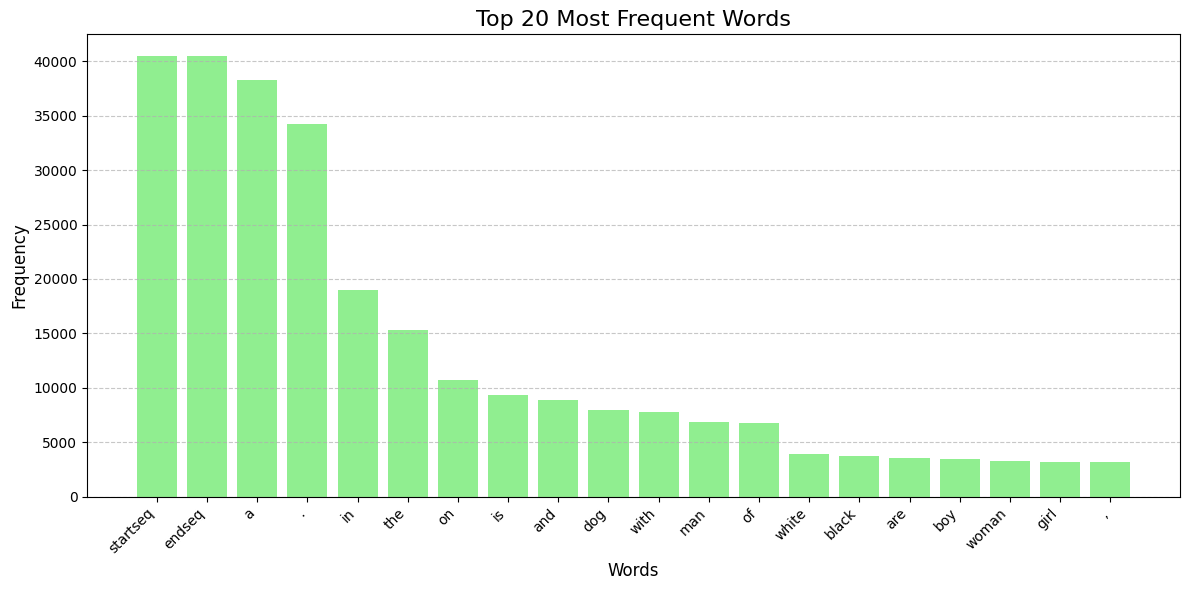

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
#Visualize Caption Lengths

all_captions = [cap for caps in mapping.values() for cap in caps]
caption_lengths = [len(s.split()) for s in all_captions]

plt.figure(figsize=(10, 5))
plt.hist(caption_lengths, bins=range(min(caption_lengths), max(caption_lengths) + 1), rwidth=0.8, color='skyblue', edgecolor='black')
plt.title('Distribution of Caption Lengths', fontsize=16)
plt.xlabel('Caption Length (words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Generate a Word Cloud of Captions
all_text = ' '.join(all_captions)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of All Captions', fontsize=16)
plt.axis('off')
plt.show()


#Bar chart of Top 20 Most Frequent Words

word_counts = Counter(all_text.split())
most_common_words = word_counts.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='lightgreen')
plt.title('Top 20 Most Frequent Words', fontsize=16)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

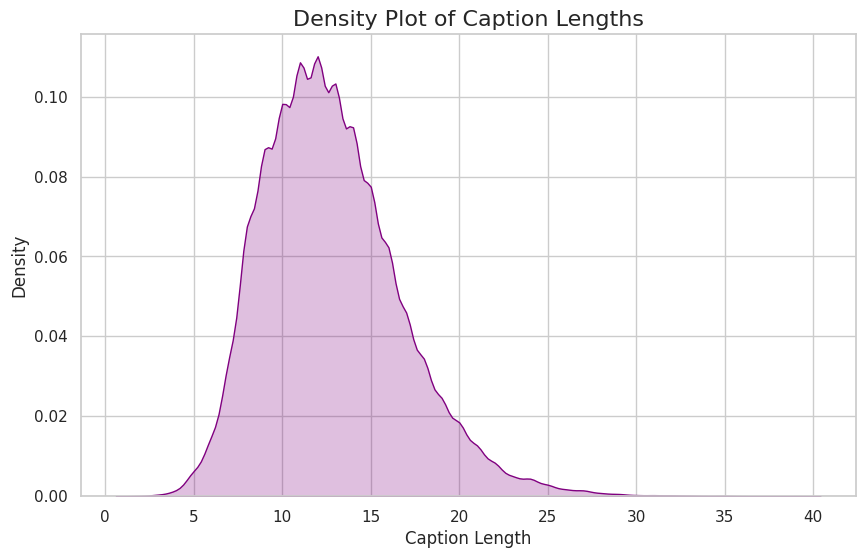

Mean Caption Length: 12.78
Median Caption Length: 12.00
Mode Caption Length: 12


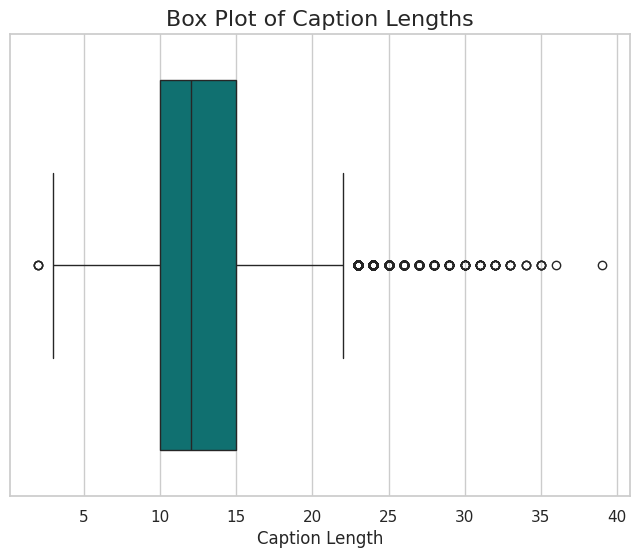

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")


#Word Count Distribution (Density Plot)
all_captions = [cap for caps in mapping.values() for cap in caps]
caption_lengths = [len(s.split()) for s in all_captions]

plt.figure(figsize=(10, 6))
sns.kdeplot(caption_lengths, fill=True, color='purple')
plt.title('Density Plot of Caption Lengths', fontsize=16)
plt.xlabel('Caption Length', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()


#Mean, Median, Mode of Caption Lengths

mean_len = np.mean(caption_lengths)
median_len = np.median(caption_lengths)
# Mode for continuous data can be found from the highest point in the histogram
from scipy import stats
mode_len = stats.mode(caption_lengths)[0]

print(f"Mean Caption Length: {mean_len:.2f}")
print(f"Median Caption Length: {median_len:.2f}")
print(f"Mode Caption Length: {mode_len}")

plt.figure(figsize=(8, 6))
sns.boxplot(x=caption_lengths, color='teal')
plt.title('Box Plot of Caption Lengths', fontsize=16)
plt.xlabel('Caption Length', fontsize=12)
plt.show()

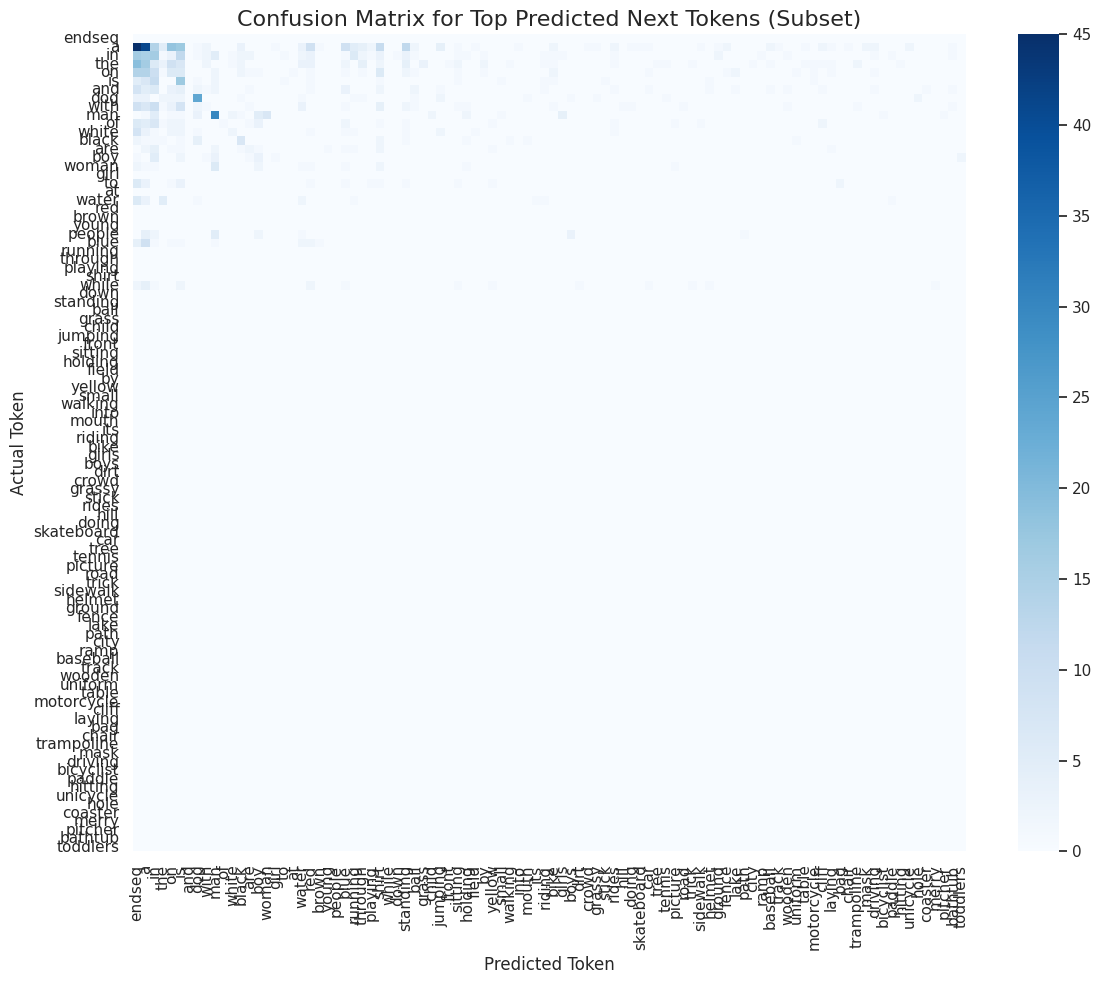

Generated confusion matrix for the top 20 most frequent actual tokens from a subset of 50 test images.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf

subset_test_ids = list(test_ids)[:50] # Use a small number for visualization

# Prepare data for the subset
subset_test_feats = np.concatenate([features[img_id] for img_id in subset_test_ids if img_id in features], axis=0).astype(np.float32)

# Generate predictions for the subset
predicted_seqs = []
for i in range(0, len(subset_test_feats), BATCH_EVAL):
    batch_feats = tf.convert_to_tensor(subset_test_feats[i:i+BATCH_EVAL])
    seqs = greedy_decode_batch(model, batch_feats, max_length, start_token, end_token).numpy().tolist()
    predicted_seqs.extend(seqs)

# Extract actual next tokens from reference captions for the subset
actual_tokens = []
predicted_tokens = []

for i, img_id in enumerate(subset_test_ids):
    if img_id not in mapping_seqs: continue
    reference_seqs = mapping_seqs[img_id]
    predicted_seq = predicted_seqs[i]

    # For each reference caption of an image
    for ref_seq in reference_seqs:
        # For each step in the predicted sequence (up to the length of the reference or max_length)
        for j in range(1, min(len(predicted_seq), len(ref_seq))):
            # Get the actual next token from the reference
            actual_tokens.append(ref_seq[j])
            # Get the predicted next token
            predicted_tokens.append(predicted_seq[j])

# Filter out tokens that are padding (0) or start/end tokens if you want to focus on content words
# You might adjust this based on what you want to visualize
actual_tokens_filtered = [t for t in actual_tokens if t != 0 and t != start_token and t != end_token]
predicted_tokens_filtered = [p for i, p in enumerate(predicted_tokens) if actual_tokens[i] != 0 and actual_tokens[i] != start_token and actual_tokens[i] != end_token]

# Ensure both lists have the same length after filtering
min_len = min(len(actual_tokens_filtered), len(predicted_tokens_filtered))
actual_tokens_filtered = actual_tokens_filtered[:min_len]
predicted_tokens_filtered = predicted_tokens_filtered[:min_len]


# Create a confusion matrix
# Due to the large vocabulary size, visualizing the full confusion matrix
# is not practical. Let's focus on the most frequent actual tokens.
# You can adjust the number of top tokens to visualize.
num_top_tokens = 20

# Get the indices of the top actual tokens
top_actual_token_indices = sorted(list(set(actual_tokens_filtered)), key=lambda x: actual_tokens_filtered.count(x), reverse=True)[:num_top_tokens]

# Filter actual and predicted tokens to only include those in the top actual tokens
actual_tokens_top = [t for t in actual_tokens_filtered if t in top_actual_token_indices]
predicted_tokens_top = [p for i, p in enumerate(predicted_tokens_filtered) if actual_tokens_filtered[i] in top_actual_token_indices]

# Re-map token indices to a smaller range for visualization if needed, or use the original indices
# For simplicity, let's use the original indices for now and map them to words for labels

# Create the confusion matrix for the top tokens
# We need to make sure the labels cover all tokens present in the filtered actual and predicted lists
all_relevant_tokens = sorted(list(set(actual_tokens_top + predicted_tokens_top)))
cm = confusion_matrix(actual_tokens_top, predicted_tokens_top, labels=all_relevant_tokens)

# Get the word labels for the confusion matrix
labels = [tokenizer.index_word.get(token, f"UNK_{token}") for token in all_relevant_tokens]

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for Top Predicted Next Tokens (Subset)', fontsize=16)
plt.xlabel('Predicted Token', fontsize=12)
plt.ylabel('Actual Token', fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"Generated confusion matrix for the top {num_top_tokens} most frequent actual tokens from a subset of {len(subset_test_ids)} test images.")

Error loading model or tokenizer: Unknown layer: 'NotEqual'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
Please make sure you have run the training and saving cells first.

--- Generated Caption ---
man in a red shirt is standing on a road

--- Original Image ---


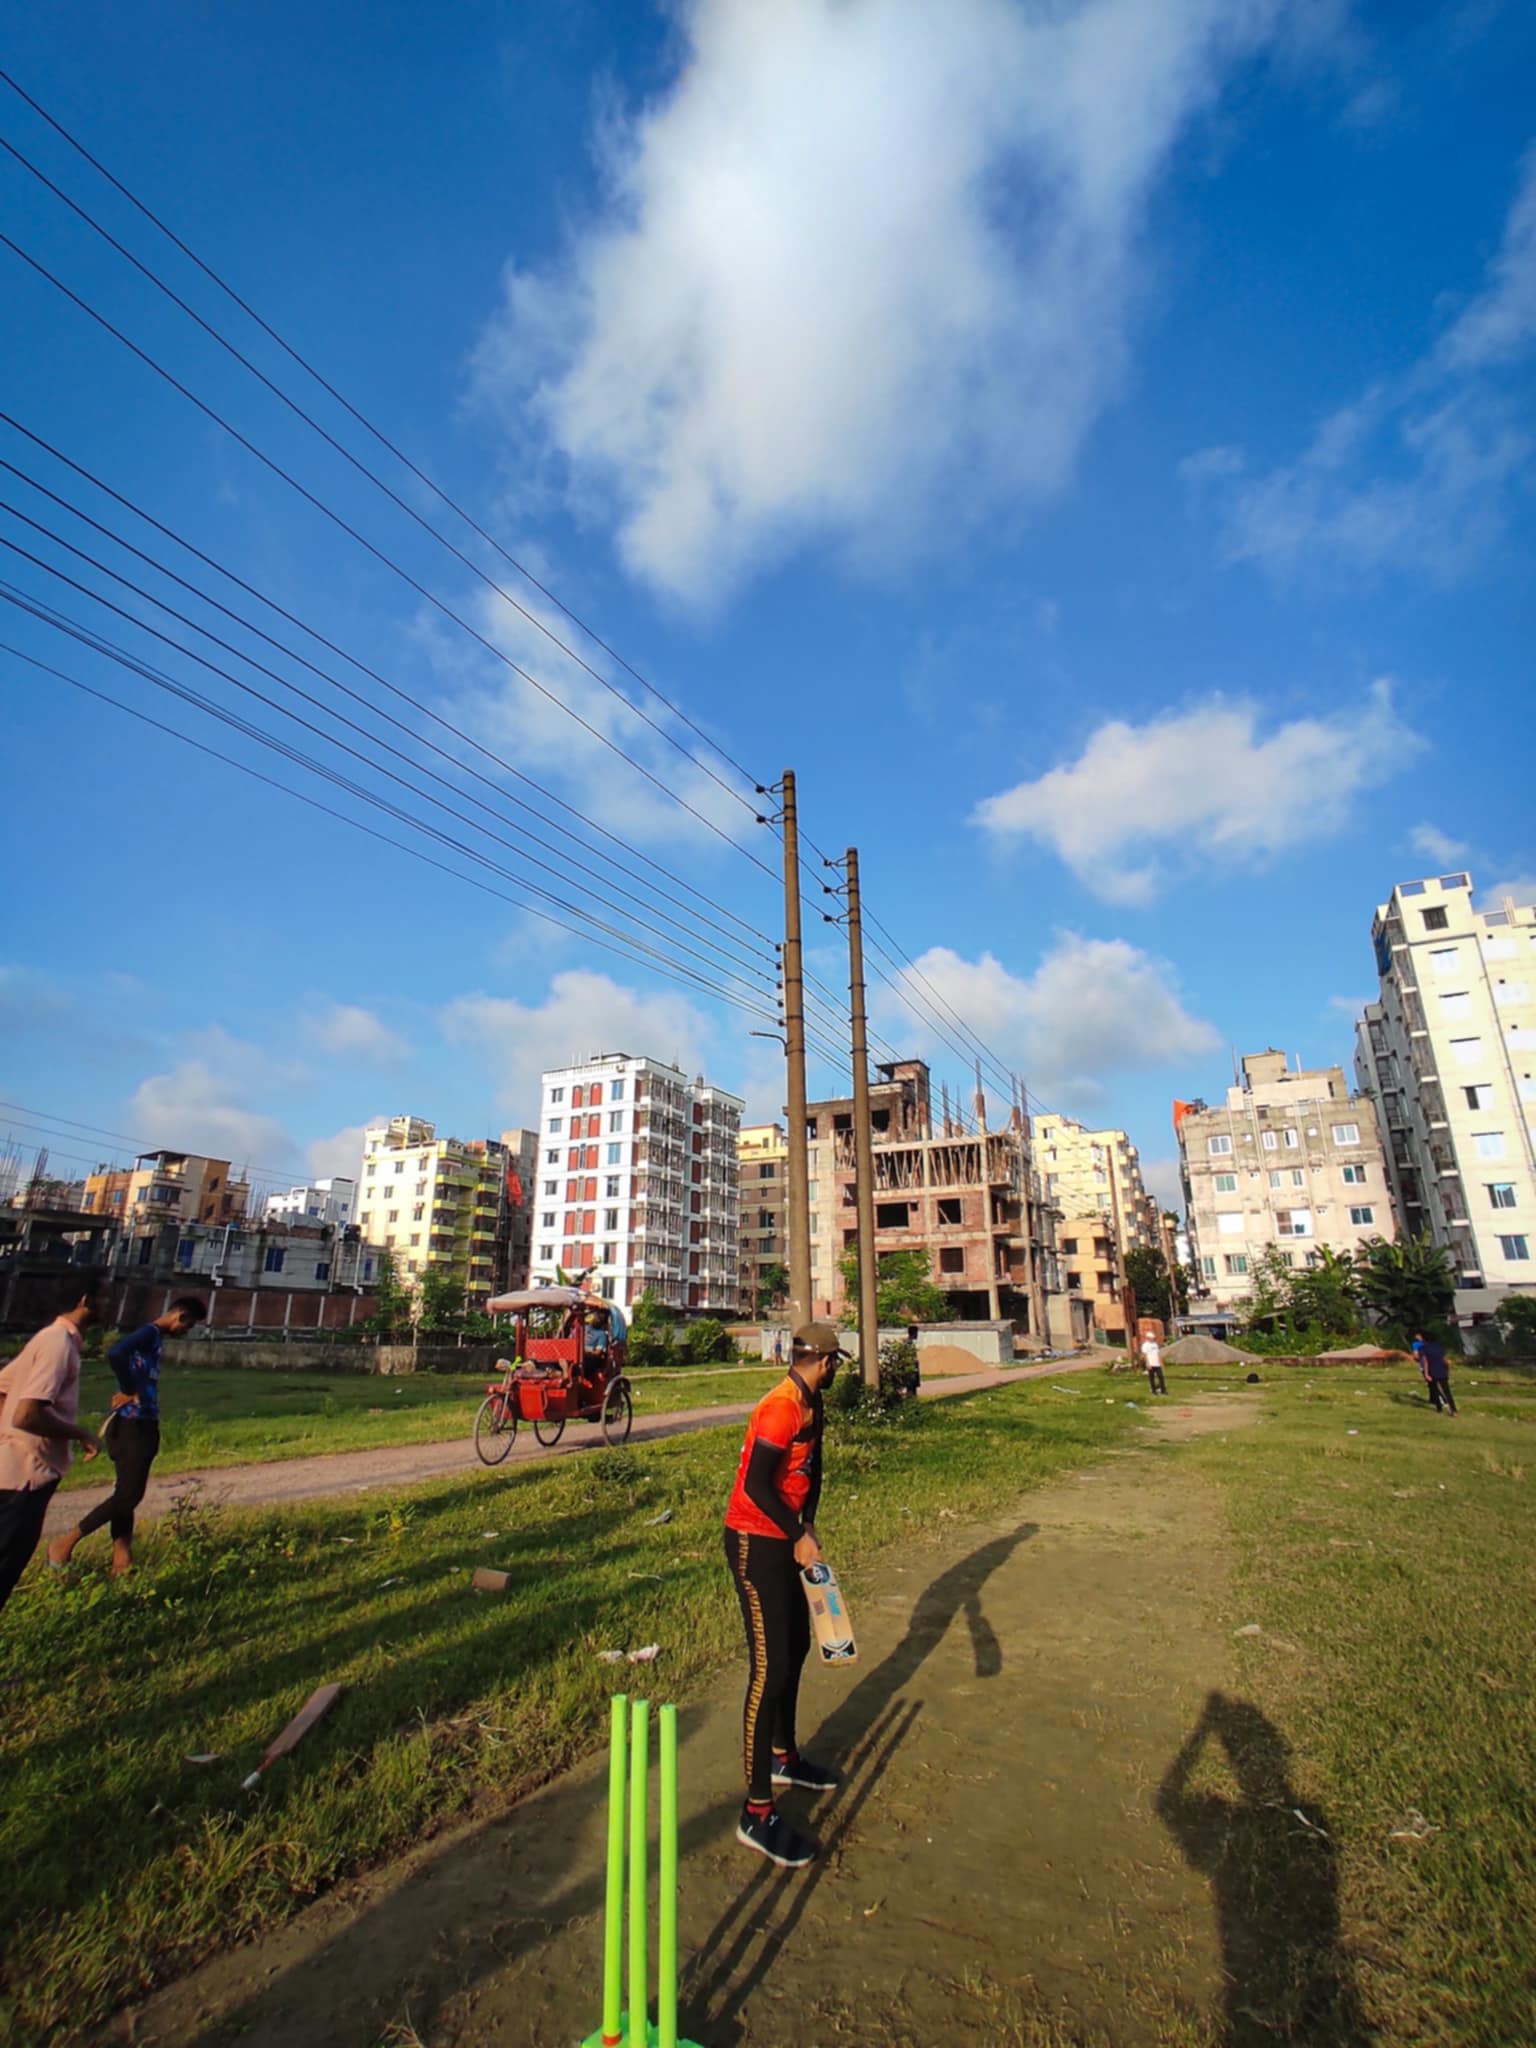

In [ ]:
#Test with a single random image

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pickle
import os
import random
from IPython.display import display, Image
IMAGE_TO_CAPTION_PATH = '/content/aftab e c.jpg'

def greedy_decode(model, photo, tokenizer, max_length, start_token, end_token):
    in_text = [tokenizer.word_index[start_token]]
    for i in range(max_length):
        sequence = tf.keras.preprocessing.sequence.pad_sequences([in_text], maxlen=max_length, padding='post')[0]
        sequence = np.reshape(sequence, (1, -1))

        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)

        word = tokenizer.index_word.get(yhat, None)
        if word is None:
            break

        in_text.append(yhat)

        if word == end_token:
            break

    final_caption = [tokenizer.index_word.get(idx, '') for idx in in_text]
    final_caption = [w for w in final_caption if w not in [start_token, end_token]]
    return ' '.join(final_caption)

WORKING_DIR = '/content/working'
model_path = os.path.join(WORKING_DIR, 'caption_model_gpu.h5')
tokenizer_path = os.path.join(WORKING_DIR, 'tokenizer.pkl')

try:
    model = tf.keras.models.load_model(model_path)
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)
    print("Model and tokenizer loaded successfully.")
except Exception as e:
    print(f"Error loading model or tokenizer: {e}")
    print("Please make sure you have run the training and saving cells first.")


max_length = model.input[1].shape[1]
start_token = 'startseq'
end_token = 'endseq'

# Preprocess the image to extract features
def extract_features_single(filename):
    """Extracts features from a single image using VGG16."""
    base_vgg = tf.keras.applications.VGG16(weights='imagenet')
    feat_model = tf.keras.models.Model(inputs=base_vgg.inputs, outputs=base_vgg.layers[-2].output)

    image = load_img(filename, target_size=(224, 224))
    image = tf.keras.utils.img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    feature = feat_model.predict(image, verbose=0)
    return feature

Image Caption Generation with Computer Vision, NLP and High Performance Computing
if os.path.exists(IMAGE_TO_CAPTION_PATH):
    # Extract features for the selected image
    photo_features = extract_features_single(IMAGE_TO_CAPTION_PATH)

    # 3. Generate the caption
    caption = greedy_decode(model, photo_features, tokenizer, max_length, start_token, end_token)

    # 4. Display the image and the generated caption
    print("\n--- Generated Caption ---")
    print(caption)
    print("\n--- Original Image ---")
    display(Image(filename=IMAGE_TO_CAPTION_PATH))
else:
    print(f"Error: The image file '{IMAGE_TO_CAPTION_PATH}' was not found.")
    print("Please update the IMAGE_TO_CAPTION_PATH variable to a valid image file path.")


--- Generating Visualizations ---

1. Plotting Loss and Accuracy...


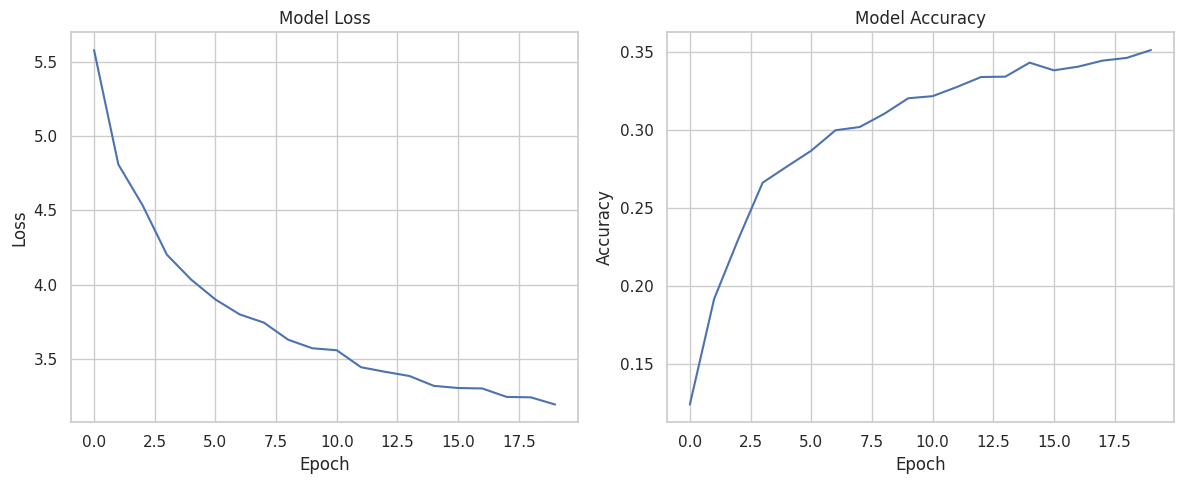


2. Plotting BLEU Scores...


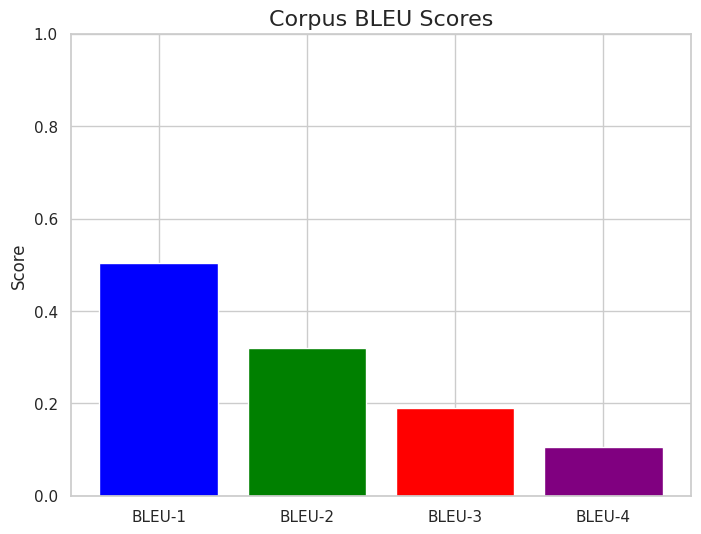


3. Generated vs. Actual Caption Comparison (Random Samples)...

Error during caption comparison: name 'preds_dict' is not defined
Please make sure you have saved the tokenizer, mapping, and predictions (preds_dict) in your working directory.


In [ ]:
# Project Visualizations

import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from IPython.display import display, Image
from nltk.translate.bleu_score import corpus_bleu
import tensorflow as tf


print("--- Generating Visualizations ---")


if 'history' in locals():
    print("\n1. Plotting Loss and Accuracy...")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.tight_layout()
    plt.show()
else:
    print("\n1. Skipping Loss and Accuracy plots. 'history' object not found.")



if 'preds' in locals() and 'refs' in locals():
    print("\n2. Plotting BLEU Scores...")
    bleu_1 = corpus_bleu(refs, preds, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(refs, preds, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(refs, preds, weights=(0.33, 0.33, 0.33, 0))
    bleu_4 = corpus_bleu(refs, preds, weights=(0.25, 0.25, 0.25, 0.25))

    bleu_scores = [bleu_1, bleu_2, bleu_3, bleu_4]
    labels = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']

    plt.figure(figsize=(8, 6))
    plt.bar(labels, bleu_scores, color=['blue', 'green', 'red', 'purple'])
    plt.title('Corpus BLEU Scores', fontsize=16)
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.show()
else:
    print("\n2. Skipping BLEU Score plot. 'preds' and 'refs' variables not found.")
    print("Please make sure you have run the evaluation cell (Cell 10) first.")



print("\n3. Generated vs. Actual Caption Comparison (Random Samples)...")
WORKING_DIR = '/content/working'
tokenizer_path = os.path.join(WORKING_DIR, 'tokenizer.pkl')
mapping_path = os.path.join(WORKING_DIR, 'mapping.pkl')
IMG_DIR = '/content/flickr8k/Images'

try:
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)
    with open(mapping_path, 'rb') as f:
        mapping = pickle.load(f)

    all_image_ids = list(mapping.keys())
    random_images = random.sample(all_image_ids, 5) # Select 5 random images

    for img_id in random_images:
        image_path = os.path.join(IMG_DIR, img_id + '.jpg')
        if os.path.exists(image_path) and img_id in preds_dict and img_id in mapping:
            generated_caption = preds_dict[img_id]
            actual_caption = random.choice(mapping[img_id])

            print(f"\n--- Image: {img_id} ---")
            print(f"Generated Caption: {generated_caption}")
            print(f"Actual Caption: {actual_caption}")
            display(Image(filename=image_path))
        else:
            print(f"Skipping image {img_id}: one or more files not found.")

except Exception as e:
    print(f"\nError during caption comparison: {e}")
    print("Please make sure you have saved the tokenizer, mapping, and predictions (preds_dict) in your working directory.")
